In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

### Set Random seed

This is to ensure results are repoducibile and consistent across runs

In [2]:
# To ensure reproducibility and consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST("./data", train=False, transform=transform, download=True)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training images: {len(train_subset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

classes = train_dataset.classes

Training images: 54000
Validation images: 6000
Test images: 10000


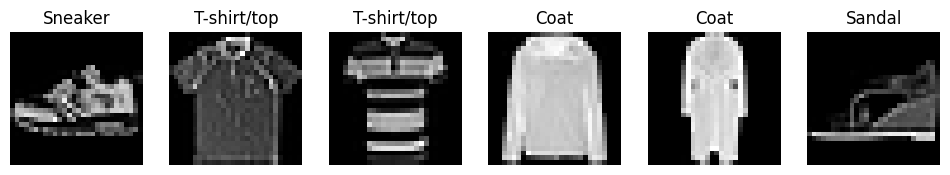

In [4]:
def show_samples():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    plt.show()

show_samples()

## MediumDeepCNN Architecture

- 5 convolution layers with ReLU

- 2× MaxPool (after conv2 and conv5) → spatial: 28 → 14 → 7

- Fully connected head: 64×7×7 → 256 → 128 → 64 → 10

Flow:
Conv1 → Conv2 + Pool → Conv3 → Conv4 → Conv5 + Pool → Flatten → FC1 → FC2 → FC4 → FC5 (logits)

Conv Layers:

- 1→32, 32→64, 64→128, 128→128, 128→64 (all 3×3, padding 1)

FC Layers:

- 3136→256 →128 →64 →10

In [5]:
class MediumDeepCNN(nn.Module):
    """5 convolution layers, better baseline accuracy."""
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # 28 → 14 → 7 after two pools
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MediumDeepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [7]:
def train_model(model, optimizer, criterion, train_loader, val_loader, device):
    patience = 5              # number of epochs to wait for improvement
    best_val_loss = np.inf
    epochs_no_improve = 0
    max_epochs = 1000         # just a safety limit
    best_model_state = None

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # -------- Validation Step --------
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:   # Make sure you have a val_loader
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # -------- Early Stopping Logic --------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print("\nEarly stopping triggered!")
            print(f"Best Validation Loss: {best_val_loss:.4f}")
            break

    # Load the best model state
    model.load_state_dict(best_model_state)
    print("Restored best model parameters.")

In [8]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    mis_images = []
    mis_preds = []
    mis_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for img, pred, label in zip(images, predicted, labels):
                if pred != label:
                    mis_images.append(img.cpu())
                    mis_preds.append(pred.item())
                    mis_labels.append(label.item())

    accuracy = 100 * correct / total
    f1_score_value = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score: {f1_score_value:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    return mis_images, mis_preds, mis_labels, all_preds, all_labels


In [9]:
train_model(model, optimizer, criterion, train_loader, val_loader, device)
mis_images, mis_preds, mis_labels, all_preds, all_labels  = evaluate_model(model, test_loader, device)

Epoch 1 | Train Loss: 0.5185 | Val Loss: 0.3591
Epoch 2 | Train Loss: 0.2999 | Val Loss: 0.2756
Epoch 3 | Train Loss: 0.2513 | Val Loss: 0.2887
  No improvement for 1 epoch(s).
Epoch 4 | Train Loss: 0.2223 | Val Loss: 0.2414
Epoch 5 | Train Loss: 0.1980 | Val Loss: 0.2413
Epoch 6 | Train Loss: 0.1735 | Val Loss: 0.2274
Epoch 7 | Train Loss: 0.1553 | Val Loss: 0.2460
  No improvement for 1 epoch(s).
Epoch 8 | Train Loss: 0.1359 | Val Loss: 0.2333
  No improvement for 2 epoch(s).
Epoch 9 | Train Loss: 0.1196 | Val Loss: 0.2488
  No improvement for 3 epoch(s).
Epoch 10 | Train Loss: 0.1058 | Val Loss: 0.2526
  No improvement for 4 epoch(s).
Epoch 11 | Train Loss: 0.0927 | Val Loss: 0.3046
  No improvement for 5 epoch(s).

Early stopping triggered!
Best Validation Loss: 0.2274
Restored best model parameters.
F1 Score: 0.9201
Test Accuracy: 91.98%


<Figure size 1600x1200 with 0 Axes>

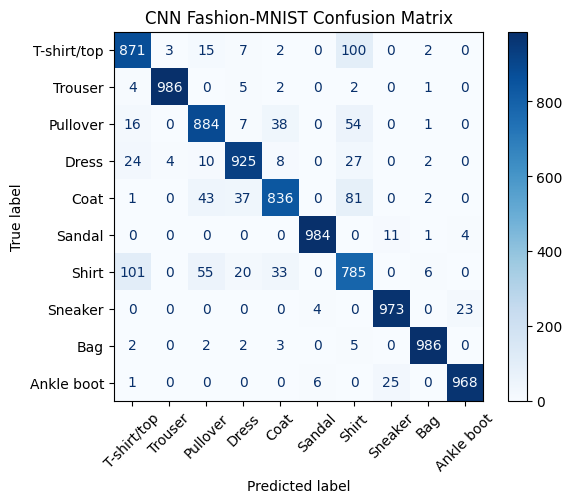

In [10]:

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(16, 12))
disp.plot(cmap="Blues", values_format="d")
plt.xticks(rotation=45)
plt.title("CNN Fashion-MNIST Confusion Matrix")
plt.show()


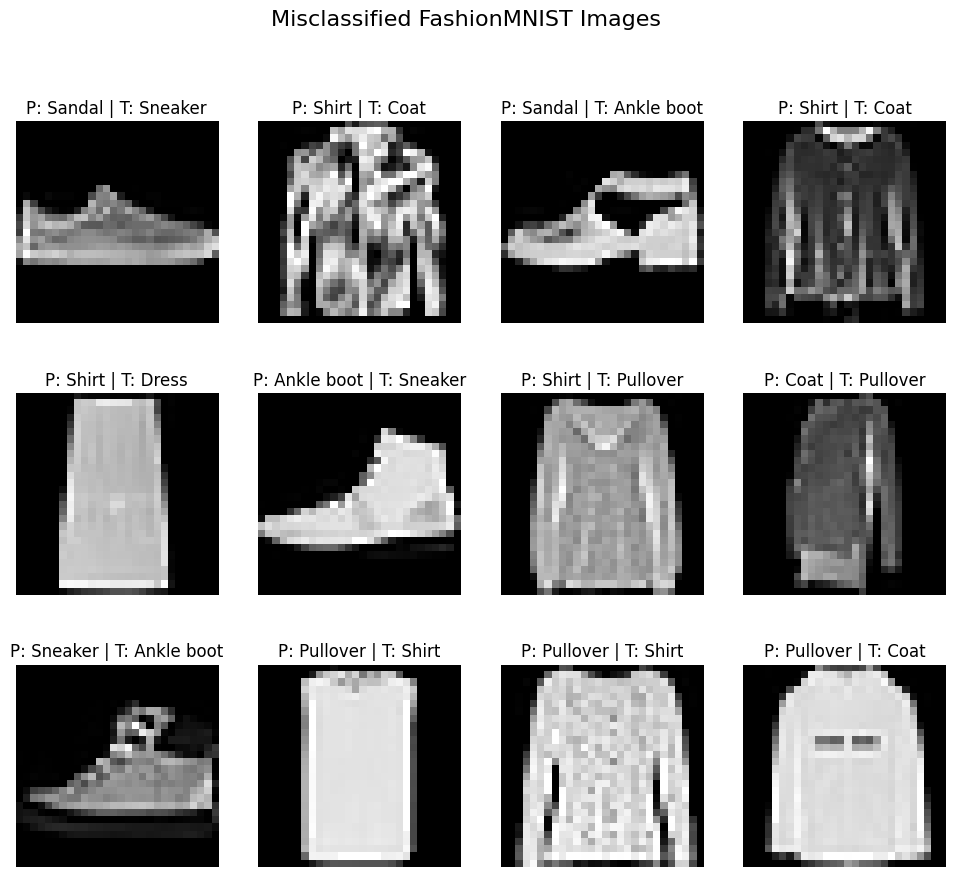

In [11]:
num_to_show = 12
plt.figure(figsize=(12, 10))
classes = test_dataset.classes

for i in range(num_to_show):
    plt.subplot(3, 4, i+1)
    plt.imshow(mis_images[i].squeeze(), cmap='gray')
    plt.title(f"P: {classes[mis_preds[i]]} | T: {classes[mis_labels[i]]}")
    plt.axis("off")

plt.suptitle("Misclassified FashionMNIST Images", fontsize=16)
plt.show()


### **VeryDeepCNN Architecture (32 Conv + 24 FC Layers)**

- **32 convolution layers** (3×3, padding=1), grouped with two max-pool operations  
  - Conv0–Conv5 → ReLU → **Pool**  
  - Conv6–Conv11 → ReLU → **Pool**  
  - Conv12–Conv23 → ReLU  

- **Feature map size:**  
  - 28×28 → 14×14 → 7×7 after two pools  
  - Final conv output: **128 × 7 × 7**

- **24 fully connected layers**  
  - Flatten (128·7·7 = 6272) → 256 → … (repeated 24×)

- **Output:**  
  - Final linear layer → **10-class logits**

**Overall flow:**  
Conv blocks → Pool ×2 → Flatten → 24× FC layers → Output layer


In [12]:
class VeryDeepCNN(nn.Module):
    """32 conv layers + 24 fully connected layers + 1 output layer."""
    def __init__(self):
        super().__init__()

        # ----- CONV BLOCK (32 layers) -----
        layers = []
        in_channels = 1
        channels = 128

        for _ in range(24):
            layers.append(nn.Conv2d(in_channels, channels, 3, padding=1))
            in_channels = channels

        self.convs = nn.ModuleList(layers)
        self.pool = nn.MaxPool2d(2, 2)

        # ----- FULLY CONNECTED BLOCK (24 layers + output) -----
        # Flatten size after two pools
        flattened = 128 * 7 * 7  
        
        fc_layers = []
        input_dim = flattened
        hidden_dim = 256

        # Create 24 fully connected layers
        for _ in range(24):
            fc_layers.append(nn.Linear(input_dim, hidden_dim))
            input_dim = hidden_dim

        self.fcs = nn.ModuleList(fc_layers)

        # Output layer (10 classes for example)
        self.output = nn.Linear(hidden_dim, 10)


    def forward(self, x):
        # ----- Convolution layers -----

        # Next 4 conv layers → pool
        for i in range(0, 6):
            x = F.relu(self.convs[i](x))
        x = self.pool(x)

        # Next conv layers (6–11)
        for i in range(6, 12):
            x = F.relu(self.convs[i](x))
        x = self.pool(x)

        for i in range(12, 24):
            x = F.relu(self.convs[i](x))


        # ----- Flatten -----
        x = x.view(x.size(0), -1)

        # ----- Fully connected layers -----
        for fc in self.fcs:
            x = F.relu(fc(x))

        # ----- Output layer -----
        return self.output(x)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = VeryDeepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


> Traning using Adam Optimizer

In [14]:
train_model(model, optimizer, criterion, train_loader, val_loader, device)
print("Very Deep CNN Evaluation using Adam Optimizer:")
mis_images, mis_preds, mis_labels, all_preds, all_labels  = evaluate_model(model, test_loader, device)

Epoch 1 | Train Loss: 2.3031 | Val Loss: 2.3028
Epoch 2 | Train Loss: 2.3028 | Val Loss: 2.3029
  No improvement for 1 epoch(s).
Epoch 3 | Train Loss: 2.3027 | Val Loss: 2.3027
Epoch 4 | Train Loss: 2.3027 | Val Loss: 2.3030
  No improvement for 1 epoch(s).
Epoch 5 | Train Loss: 2.3027 | Val Loss: 2.3032
  No improvement for 2 epoch(s).
Epoch 6 | Train Loss: 2.3027 | Val Loss: 2.3031
  No improvement for 3 epoch(s).
Epoch 7 | Train Loss: 2.3027 | Val Loss: 2.3030
  No improvement for 4 epoch(s).
Epoch 8 | Train Loss: 2.3027 | Val Loss: 2.3032
  No improvement for 5 epoch(s).

Early stopping triggered!
Best Validation Loss: 2.3027
Restored best model parameters.
Very Deep CNN Evaluation using Adam Optimizer:
F1 Score: 0.0182
Test Accuracy: 10.00%


In [15]:

model = VeryDeepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

> Training using SGD Optimizer

In [16]:
train_model(model, optimizer, criterion, train_loader, val_loader, device)
print("Very Deep CNN Evaluation using SGD Optimizer:")
mis_images, mis_preds, mis_labels, all_preds, all_labels  = evaluate_model(model, test_loader, device)

Epoch 1 | Train Loss: 2.3031 | Val Loss: 2.3038
Epoch 2 | Train Loss: 2.3031 | Val Loss: 2.3039
  No improvement for 1 epoch(s).
Epoch 3 | Train Loss: 2.3032 | Val Loss: 2.3025
Epoch 4 | Train Loss: 2.3031 | Val Loss: 2.3027
  No improvement for 1 epoch(s).
Epoch 5 | Train Loss: 2.3031 | Val Loss: 2.3030
  No improvement for 2 epoch(s).
Epoch 6 | Train Loss: 2.3030 | Val Loss: 2.3035
  No improvement for 3 epoch(s).
Epoch 7 | Train Loss: 2.3032 | Val Loss: 2.3035
  No improvement for 4 epoch(s).
Epoch 8 | Train Loss: 2.3031 | Val Loss: 2.3038
  No improvement for 5 epoch(s).

Early stopping triggered!
Best Validation Loss: 2.3025
Restored best model parameters.
Very Deep CNN Evaluation using SGD Optimizer:
F1 Score: 0.0182
Test Accuracy: 10.00%


In [17]:

model = VeryDeepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

> Traning using RMSprop Optimizer

In [18]:
train_model(model, optimizer, criterion, train_loader, val_loader, device)
print("Very Deep CNN Evaluation using RMSprop Optimizer:")
mis_images, mis_preds, mis_labels, all_preds, all_labels  = evaluate_model(model, test_loader, device)

Epoch 1 | Train Loss: 2.3031 | Val Loss: 2.3025
Epoch 2 | Train Loss: 2.3028 | Val Loss: 2.3037
  No improvement for 1 epoch(s).
Epoch 3 | Train Loss: 2.3055 | Val Loss: 2.3034
  No improvement for 2 epoch(s).
Epoch 4 | Train Loss: 2.3028 | Val Loss: 2.3030
  No improvement for 3 epoch(s).
Epoch 5 | Train Loss: 2.3027 | Val Loss: 2.3028
  No improvement for 4 epoch(s).
Epoch 6 | Train Loss: 2.3027 | Val Loss: 2.3029
  No improvement for 5 epoch(s).

Early stopping triggered!
Best Validation Loss: 2.3025
Restored best model parameters.
Very Deep CNN Evaluation using RMSprop Optimizer:
F1 Score: 0.0182
Test Accuracy: 10.00%


## Result

The Very Deep model lacked Batch Normalization and Skip Connections.
As depth increased to ~56 total layers, gradients vanished during backpropagation, trapping
the model at random guess accuracy (10%). This was concistent regardless of the optimizer used, as the same result was shown for Adam, SGD, RMSprop Optimizers 